In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk import pos_tag
import re
import heapq
import numpy as np
import mpld3
import pickle

from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, RegexpTokenizer, WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from wordcloud import WordCloud
from PIL import Image

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

In [3]:
os.chdir(r"C:\Users\jadel\Documents\OpenClassrooms\Projet 5")

In [4]:
sql_query = """
        SELECT TOP 500000 title, body, tags, id, score, viewcount, favoritecount, answercount, creationdate
        FROM Posts 
        WHERE PostTypeId = 1 AND ViewCount > 10 AND FavoriteCount > 10
        AND Score > 5 AND AnswerCount > 0 AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 3
        AND (creationdate LIKE '%2016%'
        OR creationdate LIKE '%2017%'
        OR creationdate LIKE '%2018%'
        OR creationdate LIKE '%2019%'
        OR creationdate LIKE '%2020%'
        OR creationdate LIKE '%2021%')
"""

In [5]:
df = pd.read_csv('dataset.csv', index_col = 'creationdate')
df.index = pd.to_datetime(df.index)

In [6]:
df.head()

,title,body,tags,id,score,viewcount,favoritecount,answercount
creationdate,,,,,,,,
2016-04-12 21:07:35,Should I free memory before exit?,<p>Should I free all my mallocated memory when...,<c><malloc><free><dynamic-allocation>,36584062,38,17265,14,5
2019-03-01 08:08:03,How target DOM with react useRef in map,<p>I looking for a solution about get an array...,<javascript><reactjs><react-hooks>,54940399,54,53296,20,6
2016-03-22 20:36:28,Sequelize - subquery in where clause,"<p>I'm using <a href=""http://docs.sequelizejs....",<orm><subquery><where-clause><sequelize.js>,36164694,29,27792,11,2
2016-03-22 20:52:02,'var' parameters are deprecated and will be re...,<p>Alright so I just update Xcode to 7.3 and n...,<xcode><swift><xcode7><swift3>,36164973,125,46088,16,8
2016-03-23 08:17:53,OpenCV – Depth map from Uncalibrated Stereo Sy...,<p>I'm trying to get a depth map with an uncal...,<python><opencv><stereo-3d><disparity-mapping>,36172913,180,9684,28,2


In [7]:
#nous avons plus de 13000 questions sur le dataset d'origine.

df.shape

(13867, 8)

In [8]:
#on concatène les colonnes body et title

df['body'] = df['title'] + " " + df['body']

#création d'une colonne qui garde le texte original pour comparaison avec les traitements futurs.

df['corpus'] = df['body']

In [9]:
print("le post le plus ancien date de: ",df.index.min())
print("le post le plus récent date de: ",df.index.max())

le post le plus ancien date de:  2016-01-01 14:17:47
le post le plus récent date de:  2021-12-15 04:58:02


Text(0.5, 1.0, "Distribution de l'année de publication")

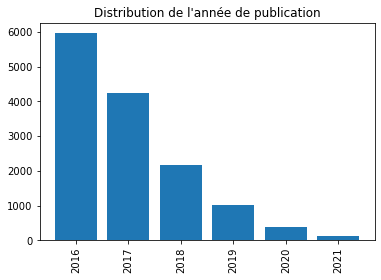

In [10]:
plt.bar(range(df.index.year.min(),df.index.year.max()+1), df.index.year.value_counts().sort_index())
plt.xticks(range(df.index.year.min(),df.index.year.max()+1), rotation=90);
plt.title("Distribution de l'année de publication")
#plus l'année est récente et moins il y a de postes

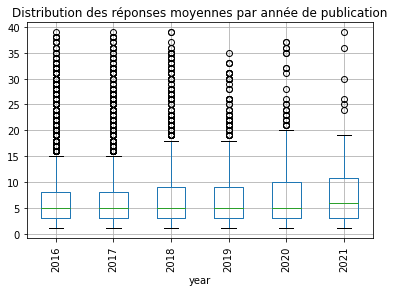

In [11]:
df['year'] = df.index.year
df[df.answercount<40].boxplot('answercount', by = 'year')
plt.xticks(rotation=90)
plt.title("Distribution des réponses moyennes par année de publication")
plt.suptitle('');
#le nombre de réponses tourne autour de 5

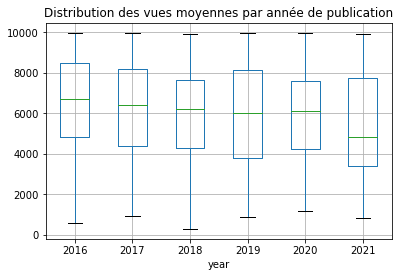

In [12]:
df[df.viewcount<10000].boxplot('viewcount', by = "year")
plt.title("Distribution des vues moyennes par année de publication")
plt.suptitle('');
#le nombre de vues tourne autour de 6000/7000. Les questions semblent donc pertinentes.

In [13]:
#seules 4 colonnes sont nécessaires pour la suite du cleaning

df = df[['title', 'body', 'tags','corpus']]

# Cleaning

# Body Cleaning

In [14]:
# test du module beautifulsoup sur le nettoyage du texte html

soup = BeautifulSoup(df['corpus'][0])
text = soup.get_text()
text

'Should I free memory before exit? Should I free all my mallocated memory when I am exiting program in the due of error?\nsomething = (char**) malloc (x * sizeof(char*));\nfor (i = 0; i < x; i++)\n    something[i] = (char*) malloc (y + 1);\n\n...\n\nif (anything == NULL) {\n   printf("Your input is wrong!");\n   // should I free memory of every mallocated entity now?\n   exit(1);\n} \nelse {\n   // work with mallocated entities\n   ...\n   free(something); // it must be here\n   system("pause);\n}\n\n'

In [15]:
#comparaison avec le texte avant traitement

df['corpus'][0]

#les balises html ont bien été traitées

'Should I free memory before exit? <p>Should I free all my mallocated memory when I am exiting program in the due of error?</p>\n\n<pre><code>something = (char**) malloc (x * sizeof(char*));\nfor (i = 0; i &lt; x; i++)\n    something[i] = (char*) malloc (y + 1);\n\n...\n\nif (anything == NULL) {\n   printf("Your input is wrong!");\n   // should I free memory of every mallocated entity now?\n   exit(1);\n} \nelse {\n   // work with mallocated entities\n   ...\n   free(something); // it must be here\n   system("pause);\n}\n</code></pre>\n'

In [16]:
def remove_ASCII(str):
    r = re.compile(r"\n|\t|\v|\b|\r|\f|\a")
    str = r.sub("",str)
    return str

In [17]:
remove_ASCII("Roses \aare \vred.\n Violets\n\t \tare \fblue")

#la fonction marche correctement

'Roses are red. Violets are blue'

In [18]:
#fonction pour enlever tous les chiffres

def remove_numbers(str):
    r = re.compile(r"\d")
    str = r.sub('', str)
    return str

In [19]:
remove_numbers("Je possède 10 chats")

#la fonction marche

'Je possède  chats'

In [20]:
#fonction qui agrège toutes les étapes de nettoyage du texte

def text_cleaning(str):
    soup = BeautifulSoup(str)
    output = soup.get_text()
    output = remove_ASCII(output)
    output = output.lower()
    output = remove_numbers(output)
    return output

In [21]:
df['title'] = df['title'].apply(text_cleaning)
df['body'] = df['body'].apply(text_cleaning)

In [22]:
#on effectue une tokenization de tous les caractères alphanumériques sans la ponctuation
tokenizer = RegexpTokenizer(r'\w+')

tokenizer.tokenize(df['body'][0])

#la tokenization fonctionne bien sur le test

['should',
 'i',
 'free',
 'memory',
 'before',
 'exit',
 'should',
 'i',
 'free',
 'all',
 'my',
 'mallocated',
 'memory',
 'when',
 'i',
 'am',
 'exiting',
 'program',
 'in',
 'the',
 'due',
 'of',
 'error',
 'something',
 'char',
 'malloc',
 'x',
 'sizeof',
 'char',
 'for',
 'i',
 'i',
 'x',
 'i',
 'something',
 'i',
 'char',
 'malloc',
 'y',
 'if',
 'anything',
 'null',
 'printf',
 'your',
 'input',
 'is',
 'wrong',
 'should',
 'i',
 'free',
 'memory',
 'of',
 'every',
 'mallocated',
 'entity',
 'now',
 'exit',
 'else',
 'work',
 'with',
 'mallocated',
 'entities',
 'free',
 'something',
 'it',
 'must',
 'be',
 'here',
 'system',
 'pause']

In [23]:
wnl = WordNetLemmatizer()

morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}

def penn2morphy(penntag):

    """ Converts Penn Treebank tags to WordNet. """

    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize(list): 
    # Text input is string, returns lowercased strings.
    
    return [wnl.lemmatize(word, pos=penn2morphy(tag))
        for word, tag in pos_tag(list)]

In [24]:
#test de la lemmatization

print(lemmatize(["I", "am", "going", "to", "a", "meeting"]))
print(lemmatize(["I", "am", "meeting", "you", "later"]))

#la lemmatization fonctionne et fait bien la différence entre meeting verbe et nom

['I', 'be', 'go', 'to', 'a', 'meeting']
['I', 'be', 'meet', 'you', 'later']


In [25]:
#on crée le set de tous les stop words anglais
stop_words = set(stopwords.words('english'))
print(stop_words)

{"wouldn't", 'and', "couldn't", 'didn', 'shan', 'hadn', 'in', "weren't", 'such', 'mightn', 'through', 'haven', 'so', 'couldn', 'm', 'y', 'aren', 'during', 'against', "hadn't", 'below', 'hers', 'yourself', 'other', "you're", 'should', 'weren', 'her', 'down', 'then', "that'll", 'if', "doesn't", 'off', 'on', 'very', "you'll", 'its', 'will', 'shouldn', 'of', 'most', 'by', 'this', 'only', 'hasn', 'more', "she's", 'their', 'until', "won't", 'at', 'but', 'is', 'wouldn', 'nor', 'they', 'above', "should've", 'before', 'here', 'ourselves', 'further', 'don', "shouldn't", 'few', 'do', "you've", "mustn't", 've', 'my', 'those', "wasn't", 'been', 'as', 'ma', 'd', 'll', "shan't", 'an', 'no', 'yourselves', 'about', 're', 'can', 'did', 'we', 'herself', 'was', 'i', 'who', 'to', 'had', 'it', 'him', 'you', 'these', 'all', 'that', 'because', 'the', 'himself', 'with', 'not', 'while', 'me', 'same', 'doing', "haven't", "don't", 'his', 'themselves', 'where', 'wasn', 'won', 'needn', "you'd", 'myself', 'isn', 'do

In [26]:
#fonction qui applique le filtre stop words à chaque mot dans le token

def stop_words_filtering(list):
    token = [word for word in list if word not in stop_words]
    return token

In [27]:
#test de la fonction supprimant les stopwords

stop_words_filtering(["i", "love", "going", "to", "the", "restaurant"])

#la fonctionne marche correctement

['love', 'going', 'restaurant']

In [28]:
#fonction qui agrège toutes les étapes de tokenization

def tokenization_customized(str):
    output = tokenizer.tokenize(str)
    output = lemmatize(output)
    output = stop_words_filtering(output)
    return output

In [29]:
#application aux colonnes title et body
df['title'] = df['title'].apply(tokenization_customized)
df['body'] = df['body'].apply(tokenization_customized)

In [30]:
#création variable wordfreq qui donne l'occurence de tous les mots tokenizés 

wordfreq = {}
for tokens in df['body']:
    for token in tokens :
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

In [31]:
#distribution des mots

pd.Series(wordfreq).sort_values(ascending = False)[:50]


use          19418
android      10632
get           9863
file          9753
error         9211
app           8489
try           7833
class         7493
new           7336
code          7011
data          6985
user          6952
return        6803
java          6768
work          6643
run           6639
com           6597
like          6449
name          5777
c             5582
function      5554
import        5462
x             5349
find          5168
http          5123
value         5078
build         5055
string        4902
create        4868
python        4780
want          4764
id            4673
type          4613
version       4599
j             4315
add           4310
way           4275
test          4222
component     4189
one           4101
project       3949
would         3948
v             3863
set           3849
react         3788
div           3746
need          3704
package       3691
public        3658
true          3617
dtype: int64

In [32]:
stop_words.update({'use', 'get', 'file', 'error', 'try',
                   'new', 'code', 'work', 'run', 'like',
                   'name', 'find', 'build', 'create',
                    'want', 'id', 'add', 'way', 'test',
                  'component', 'one', 'would', 'need'})

In [33]:
df['body'] = df['body'].apply(stop_words_filtering)


In [34]:
#vérification de la présence de posts vides

df[df['body'].apply(len)==0]

,title,body,tags,corpus
creationdate,,,,
2016-07-01 10:53:19,[],[],<html><css><script-tag>,When should <script> tags be visible and why c...


In [35]:
df = df[~(df['body'].apply(len)==0)]

# Tag cleaning

In [36]:
#fonction pour nettoyer les <>

r = re.compile(r"><|<|>") 

def tags_removal(text):

    pointer = r.findall(text)
    return r.sub(' ', text)

In [37]:
#nettoyage des balises <>

df['tags'] = df['tags'].apply(tags_removal)

#tokenization des tags par espace

df['tags'] = df['tags'].apply(WhitespaceTokenizer().tokenize)
df['tags']

creationdate
2016-04-12 21:07:35                [c, malloc, free, dynamic-allocation]
2019-03-01 08:08:03                   [javascript, reactjs, react-hooks]
2016-03-22 20:36:28          [orm, subquery, where-clause, sequelize.js]
2016-03-22 20:52:02                       [xcode, swift, xcode7, swift3]
2016-03-23 08:17:53       [python, opencv, stereo-3d, disparity-mapping]
                                             ...                        
2018-12-30 16:32:55                          [python, pandas, dataframe]
2018-12-31 06:03:36    [python, python-3.x, string, boolean-expressio...
2019-01-01 13:44:26               [angular, build, production, ng-build]
2019-01-01 16:40:55                  [node.js, npm, chromium, puppeteer]
2019-01-01 19:23:26    [python, memory-management, deep-learning, pyt...
Name: tags, Length: 13866, dtype: object

In [39]:
#liste des tags avec leur occurence

tags_list = pd.Series([x for item in df.tags for x in item]).value_counts()

print(f"On conserve {len(tags_list[tags_list>100])} des tags en ne gardant que ceux ayant une occurence >100")

On conserve 75 des tags en ne gardant que ceux ayant une occurence >100


In [40]:
#procédure d'élimination des tags peu fréquents


tags_to_remove = tags_list[~(tags_list>100)].index #liste des tags peu fréquents à retirer

tags_list = tags_list[tags_list>100].index #liste des tags fréquents à garder

#fonction qui retire les tags peu fréquents

def tags_removal(list):
    for word in tags_to_remove:
        while word in list:
            list.remove(word)
    return list

In [41]:
#on applique la procédure d'élimination des tags peu fréquents

df['tags'] = df['tags'].apply(tags_removal)

In [42]:
#on se retrouve avec 2133 topics sans tags

df['tags'].apply(len).value_counts().sort_index()

0    1136
1    4890
2    5130
3    2231
4     427
5      52
Name: tags, dtype: int64

In [43]:
#suppression des lignes sans tags

df = df[~(df['tags'].apply(len)==0)]

In [44]:
sorted(tags_list)
#python-3.x, .net-core, apache-spark-sql, asp.net-core, docker-compose,
#spring boot, et vuejs2 sont à remplacer et supprimer

['.net',
 '.net-core',
 'amazon-web-services',
 'anaconda',
 'android',
 'android-studio',
 'angular',
 'apache-spark',
 'apache-spark-sql',
 'arrays',
 'asp.net',
 'asp.net-core',
 'bash',
 'c',
 'c#',
 'c++',
 'css',
 'dart',
 'dataframe',
 'deep-learning',
 'django',
 'docker',
 'docker-compose',
 'ecmascript-6',
 'firebase',
 'flutter',
 'git',
 'github',
 'google-chrome',
 'gradle',
 'html',
 'ios',
 'java',
 'javascript',
 'jquery',
 'json',
 'jupyter-notebook',
 'keras',
 'kotlin',
 'laravel',
 'linux',
 'machine-learning',
 'macos',
 'matplotlib',
 'mysql',
 'neural-network',
 'node.js',
 'npm',
 'numpy',
 'pandas',
 'performance',
 'php',
 'pip',
 'pyspark',
 'python',
 'python-3.x',
 'r',
 'react-native',
 'react-router',
 'reactjs',
 'redux',
 'scikit-learn',
 'spring',
 'spring-boot',
 'swift',
 'tensorflow',
 'typescript',
 'ubuntu',
 'unit-testing',
 'visual-studio-code',
 'vue.js',
 'vuejs2',
 'webpack',
 'windows',
 'xcode']

In [45]:
#fonction qui sert à regrouper tous les tags similaires

def regroupement_tag(liste_tag, tag):
    for word in list(liste_tag): #itération sur les tags du post
        if tag in liste_tag: #cas où le tag à regrouper est dans la liste
            if word == tag: #si le tag est égal au tag à regrouper, on passe au tag suivant
                continue
            elif tag in word: #si le tag contient le tag à regrouper, on élimine le mot
                liste_tag.remove(word)
        elif tag not in list(liste_tag): #cas où le tag n'est pas dans la liste
            if tag in word: #si le tag contient le tag à regrouper, on le remplace par le tag à regrouper
                liste_tag[liste_tag.index(word)] = tag
    return liste_tag

In [46]:
pd.Series([x for item in df.tags for x in item if 'python' in x]).value_counts(normalize=True)*100

python        86.621571
python-3.x    13.378429
dtype: float64

In [47]:
#application de la procédure de regroupement des tags sur python

df['tags'] = df['tags'].apply(lambda x : regroupement_tag(x, 'python'))
pd.Series([x for item in df.tags for x in item if 'python' in x]).value_counts(normalize=True)*100

#tous les tags concernant python ont bien été regroupés

python    100.0
dtype: float64

In [48]:
pd.Series([x for item in df.tags for x in item if '.net' in x]).value_counts(normalize=True)*100

asp.net-core    42.031030
.net-core       22.708039
.net            20.592384
asp.net         14.668547
dtype: float64

In [49]:
#application de la procédure de regroupement des tags sur .net

df['tags'] = df['tags'].apply(lambda x : regroupement_tag(x, '.net'))
pd.Series([x for item in df.tags for x in item if '.net' in x]).value_counts(normalize=True)*100

#tous les tags concernant .net ont bien été regroupés

.net    100.0
dtype: float64

In [50]:
pd.Series([x for item in df.tags for x in item if 'apache-spark' in x]).value_counts(normalize=True)*100

apache-spark        62.295082
apache-spark-sql    37.704918
dtype: float64

In [51]:
#application de la procédure de regroupement des tags sur apache-spark

df['tags'] = df['tags'].apply(lambda x : regroupement_tag(x, 'apache-spark'))
pd.Series([x for item in df.tags for x in item if 'apache-spark' in x]).value_counts(normalize=True)*100

#tous les tags concernant apache-spark ont bien été regroupés

apache-spark    100.0
dtype: float64

In [52]:
pd.Series([x for item in df.tags for x in item if 'docker' in x]).value_counts(normalize=True)*100

docker            78.361345
docker-compose    21.638655
dtype: float64

In [53]:
#application de la procédure de regroupement des tags sur docker

df['tags'] = df['tags'].apply(lambda x : regroupement_tag(x, 'docker'))
pd.Series([x for item in df.tags for x in item if 'docker' in x]).value_counts(normalize=True)*100

#tous les tags concernant docker ont bien été regroupés

docker    100.0
dtype: float64

In [54]:
pd.Series([x for item in df.tags for x in item if 'spring' in x]).value_counts(normalize=True)*100

spring         55.306122
spring-boot    44.693878
dtype: float64

In [55]:
#application de la procédure de regroupement des tags sur spring

df['tags'] = df['tags'].apply(lambda x : regroupement_tag(x, 'spring'))
pd.Series([x for item in df.tags for x in item if 'spring' in x]).value_counts(normalize=True)*100

#tous les tags concernant spring ont bien été regroupés

spring    100.0
dtype: float64

In [56]:
def replace_vusjs2(liste_tag):
    for word in list(liste_tag): #itération sur les tags du post
        if 'vue.js' in liste_tag: #cas où le tag à regrouper est dans la liste
            if word == 'vue.js': #si le tag est égal au tag à regrouper, on passe au tag suivant
                continue
            elif word == 'vuejs2': #si le tag contient le tag à regrouper, on élimine le mot
                liste_tag.remove(word)
        elif 'vue.js' not in list(liste_tag): #cas où le tag n'est pas dans la liste
            if word == 'vuejs2': #si le tag contient le tag à regrouper, on le remplace par le tag à regrouper
                liste_tag[liste_tag.index(word)] = 'vue.js'
    return liste_tag

In [57]:
pd.Series([x for item in df.tags for x in item if 'vue' in x]).value_counts(normalize=True)*100

vue.js    64.942529
vuejs2    35.057471
dtype: float64

In [58]:
#application de la procédure de regroupement des tags sur vue.js

df['tags'].apply(replace_vusjs2)
pd.Series([x for item in df.tags for x in item if 'vue' in x]).value_counts(normalize=True)*100

#tous les tags concernant vue.js ont bien été regroupés

vue.js    100.0
dtype: float64

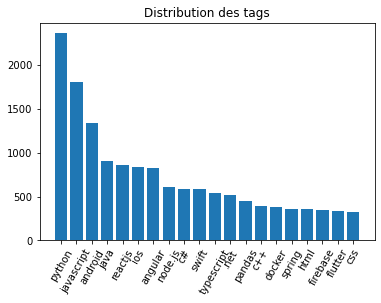

In [59]:
#distribution des tags
tags_list = pd.Series([x for item in df.tags for x in item]).value_counts()

plot = plt.bar(tags_list[:20].index, tags_list[:20].values)
plt.xticks(rotation=60)
plt.title(f"Distribution des tags");

# Analyse exploratoire

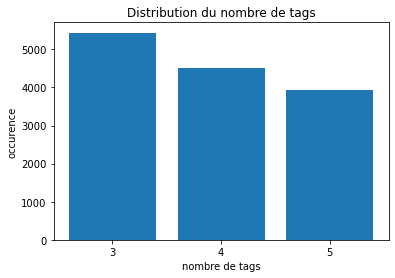

In [38]:
#analyse de la distribution du nombre de tags dans un post
plt.bar(range(3,6), df['tags'].apply(len).value_counts().sort_index())
plt.xticks([3,4,5])
plt.xlabel('nombre de tags')
plt.ylabel('occurence')
plt.title('Distribution du nombre de tags');

In [60]:
df.shape

# 80% des posts sont conservés après nettoyage

(12730, 4)

In [61]:
len(tags_list)

#nous gardons une liste finale de 49 tags

67

In [62]:
tags_list

python                 2359
javascript             1805
android                1339
java                    908
reactjs                 861
ios                     840
angular                 826
node.js                 611
c#                      589
swift                   582
typescript              545
.net                    521
pandas                  454
c++                     394
docker                  376
spring                  357
html                    355
firebase                346
flutter                 331
css                     325
xcode                   291
tensorflow              283
dataframe               252
php                     251
machine-learning        250
dart                    244
git                     239
vue.js                  238
apache-spark            232
npm                     230
android-studio          229
macos                   223
json                    218
keras                   210
numpy                   202
react-native        

Text(0.5, 1.0, 'Distribution de la longueur des posts')

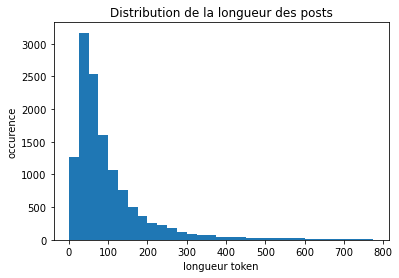

In [63]:
#distribution de la longueur des tokens de posts

plt.hist(df['body'].apply(len), bins = np.arange(0,800,25));
plt.xlabel('longueur token')
plt.ylabel('occurence')
plt.title('Distribution de la longueur des posts')
#pic aux alentours de 50 mots

In [64]:
#création variable wordfreq qui donne l'occurence de tous les mots tokenizés 

wordfreq = {}
for tokens in df['body']:
    for token in tokens :
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

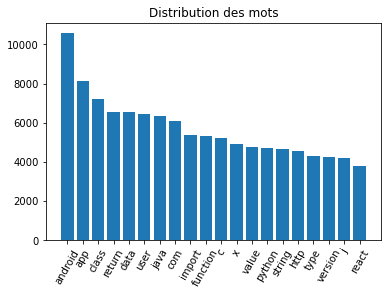

In [65]:
#distribution des mots

plot = plt.bar(pd.Series(wordfreq).sort_values(ascending = False)[:20].index,
               pd.Series(wordfreq).sort_values(ascending = False)[:20].values)
plt.xticks(rotation=60)
plt.title(f"Distribution des mots");

In [66]:
#création d'un objet text contenant tous les mots tokenizes 

text = ""
for post in df['body']:
    text += " ".join(post)

In [67]:
#fonction qui crée un wordcloud avec un masque prédéfini

def plot_word_cloud(text, masque, background_color = "white") :
    # Définir un masque
    mask_coloring = np.array(Image.open(str(masque)))

    # Définir le calque du nuage des mots
    wc = WordCloud(background_color=background_color, mask = mask_coloring, max_font_size=25)

    # Générer et afficher le nuage de mots
    plt.figure(figsize= (20,10))
    wc.generate(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

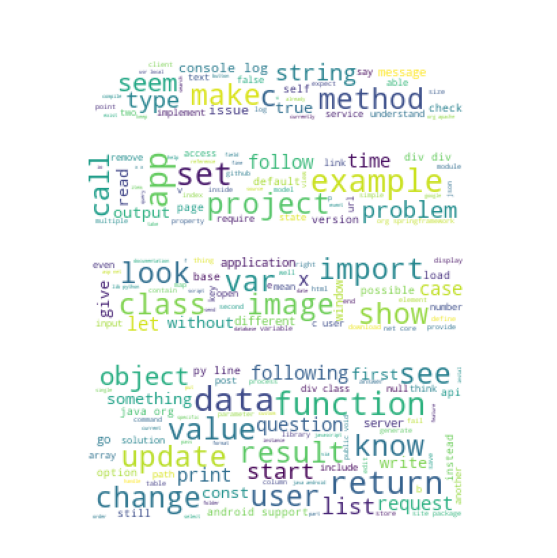

In [68]:
#fonction appliquée à tout le texte

plot_word_cloud(text, "Images\stack_overflow.png")

In [69]:
#fonction qui, pour un tag donné, crée un texte à processer pour le wordcloud

def text_by_tag(tag):
    text = ""
    for tokens, tags in zip(df['body'], df['tags']):
        if tag in tags:
            text += " ".join(tokens)

    return text

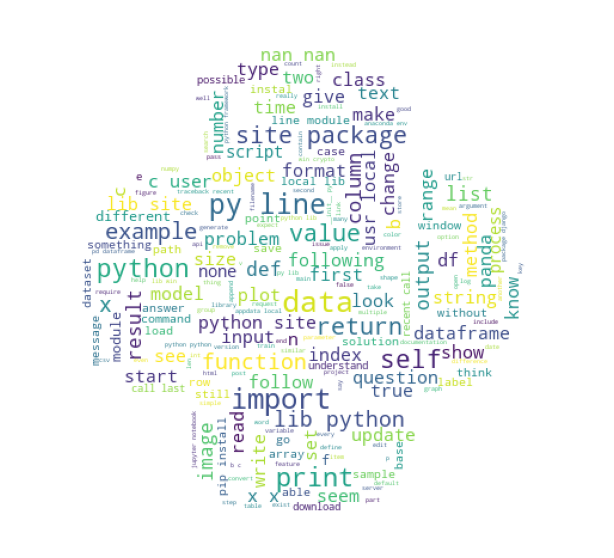

In [70]:
#wordcloud des posts avec le tag python

plot_word_cloud(text_by_tag('python'), 'Images\python.jpg')

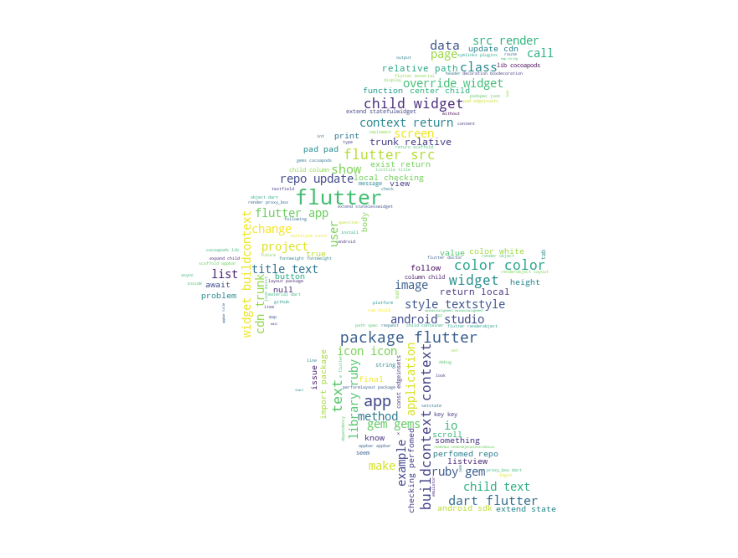

In [71]:
#wordcloud des posts avec le tag flutter

plot_word_cloud(text_by_tag('flutter'), "Images\\flutter.jpg");

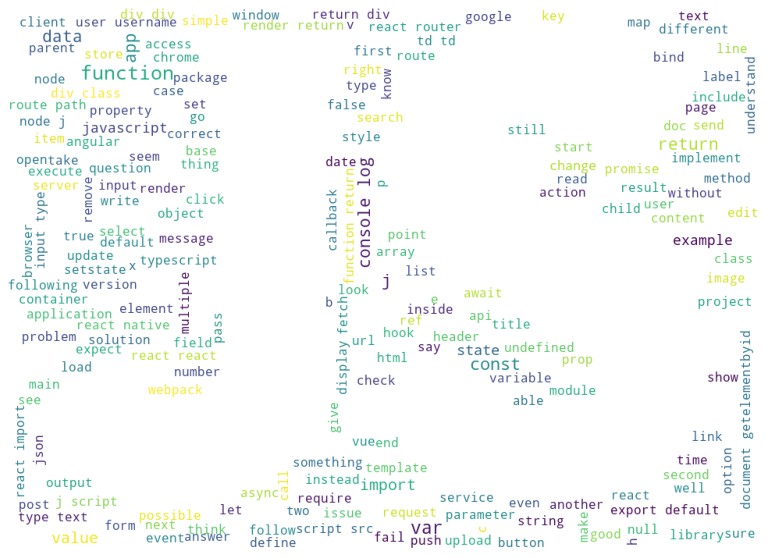

In [72]:
#wordcloud des posts avec le tag flutter

plot_word_cloud(text_by_tag('javascript'), "Images\\javascript.png");

In [73]:
#fonction qui, pour un tag donné, établit la liste des mots et leur fréquence

def word_count_by_tag(tag):
    wordfreq = {}
    for tokens, tags in zip(df['body'], df['tags']):
        if tag in tags:
            for token in tokens :
                if token not in wordfreq.keys():
                    wordfreq[token] = 1
                else:
                    wordfreq[token] += 1
    return pd.Series(wordfreq).sort_values(ascending = False)

In [74]:
#fonction qui crée un graphique de distribution des mots pour un tag donné

def graph_words_by_tag(tag):
    plot = plt.bar(word_count_by_tag(tag)[:20].index, word_count_by_tag(tag)[:20].values)
    plt.xticks(rotation=60)
    plt.title(f"Distribution des mots (tag: {tag})");
    return plot;

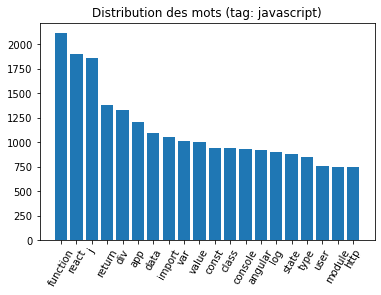

In [75]:
#application à javascript

graph_words_by_tag('javascript');

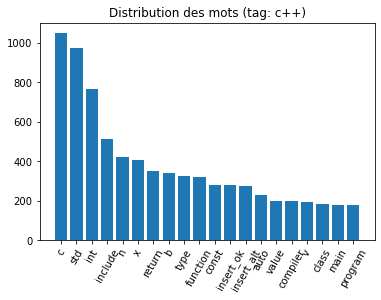

In [76]:
#application à C++

graph_words_by_tag('c++');

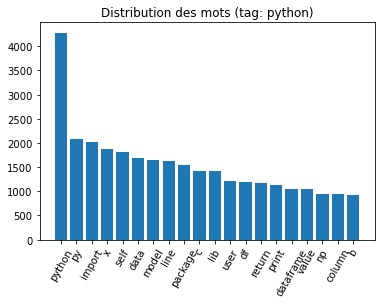

In [77]:
#application à python

graph_words_by_tag('python');

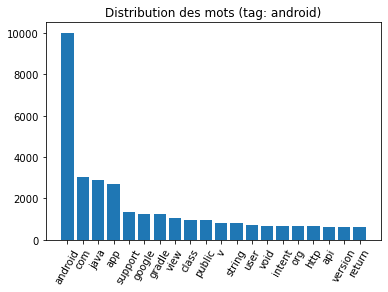

In [78]:
#application à android

graph_words_by_tag('android');

In [79]:
df.to_csv('dataset_clean.csv')